# convertion between panorama and cubemap
This notebook shows convertion between panorama and cubemap, mainly following [link](https://medium.com/check-visit-computer-vision/understanding-360-images-8e0fcf0ee861). The mathematical principle is discribed in the link above and we show the code and result here.

In [1]:
# import libraries needed for image processing and visualization
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

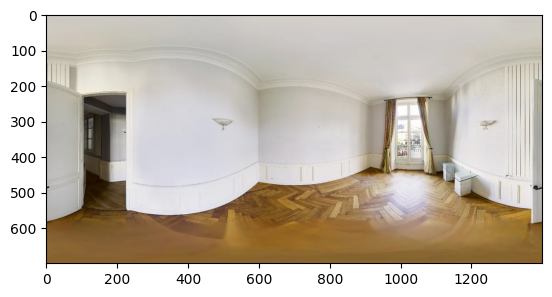

In [2]:
# read in the image and show it
image = cv2.imread('data/room.webp')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

For every face in the cubemap, we calculate the phi and theta coordinates of the corresponding pixel in the panorama image. Then the calculated phi and theta are used to sample the pixel value from the panorama image.

In [3]:
# convert image into ndarray
image = np.array(image)
# print shape and height and width of the image
print("Shape of the image ndarray: ", image.shape)
print("Height of the image: ", image.shape[0])
print("Width of the image: ", image.shape[1])

Shape of the image ndarray:  (700, 1400, 3)
Height of the image:  700
Width of the image:  1400


In case you are not very familiar with the [meshgrid](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html)

In [4]:
ni, nj = (3, 2)
i = np.linspace(0, 1, ni)
j = np.linspace(0, 1, nj)
iv, jv = np.meshgrid(i, j, indexing='ij')
print("iv: ")
print(iv)
print("jv: ")
print(jv)

iv: 
[[0.  0. ]
 [0.5 0.5]
 [1.  1. ]]
jv: 
[[0. 1.]
 [0. 1.]
 [0. 1.]]


In [5]:
def sample_pixels(begin: float, end: float, n: int) -> np.ndarray:
    """
    Sample pixel values of an affine function, which is equal
    to "begin" on the far left and "end" on the far right.
    """
    x_coords = 0.5 + np.arange(n, dtype=np.float32)
    return begin + (end-begin) * x_coords / n  # ]begin, end[

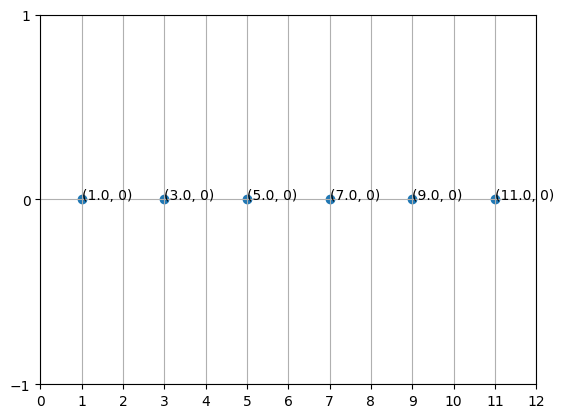

In [6]:
# visualize sampled pixels with matplotlib in scatter plot
n = 6
start = 0
end = 12
# plt.scatter(sample_pixels(0, 10, n), np.zeros(n))
# with grid and every point's coordinate
plt.scatter(sample_pixels(start, end, n), np.zeros(n))
for i in range(n):
    plt.text(sample_pixels(start, end, n)[i], 0, f"({sample_pixels(start, end, n)[i]}, 0)")
# define x range and y range
plt.xlim(start, end)
plt.ylim(-1, 1)
# define grid size: every 1 unit
plt.xticks(np.arange(start, end+1, 1))
plt.yticks(np.arange(-1, 2, 1))
plt.grid()
plt.show()

In [7]:
from typing import List
import cv2
import numpy as np


def equirec_to_cubemap(equirec: np.ndarray, out_size: int) -> List[np.ndarray]:
    """Convert an equirectangular image to a list of cubefaces (FRBLUD)"""
    height, width = equirec.shape[:2]

    u, v = np.meshgrid(sample_pixels(-1, 1, out_size),
                       sample_pixels(-1, 1, out_size),
                       indexing="ij")
    ones = np.ones((out_size, out_size), dtype=np.float32)

    # x right, y down, z front
    list_xyz = [
        (v, u, ones),    # FRONT
        (ones, u, -v),   # RIGHT
        (-v, u, -ones),  # BACK
        (-ones, u, v),   # LEFT
        (v, -ones, u),   # UP
        (v, ones, -u)    # DOWN
    ]

    faces = []
    r = np.sqrt(u**2 + v**2 + 1) # Same values for each face
    for x, y, z in list_xyz:
        # Camera Convention RIGHT_DOWN_FRONT
        phi = np.arcsin(y/r)  # in [-pi/2, pi/2]
        theta = np.arctan2(x, z)  # in [-pi, pi]

        phi_map = (phi/np.pi + 0.5) * height
        theta_map = (theta/(2*np.pi) + 0.5) * width
    
        # Opencv shift
        theta_map -= 0.5
        phi_map -= 0.5
        
        faces.append(cv2.remap(equirec, theta_map, phi_map, cv2.INTER_CUBIC,
                               borderMode=cv2.BORDER_WRAP))
    return faces

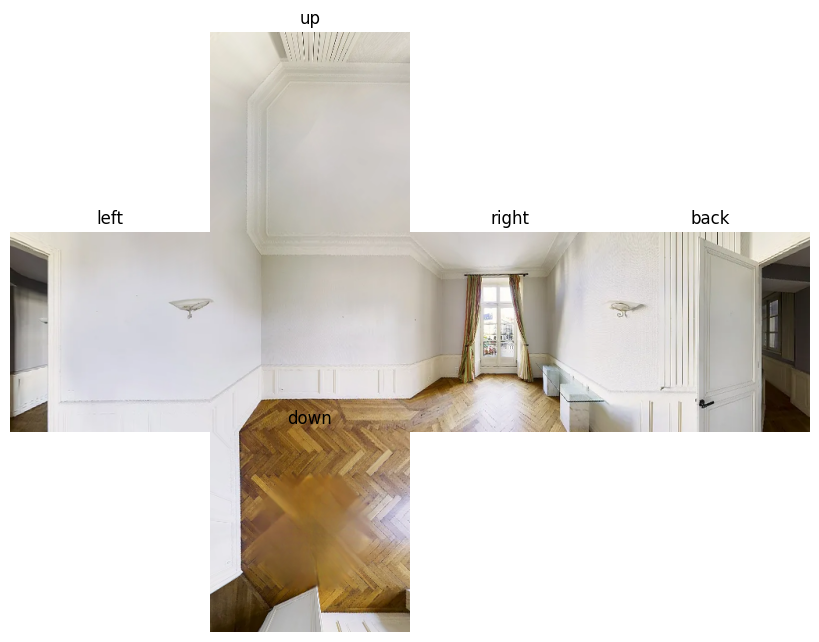

In [8]:
# convert and visualize all faces, put them in a dense aligned grid, front, right, back, left, up, down in an order like
# ------ up     ------
# left front right back
# ------ down    ------
faces = equirec_to_cubemap(image, 256)

def plot_face(ax, face, title):
    ax.imshow(face)
    ax.set_title(title)
    # set title at the center of ax
    ax.axis('off')
fig = plt.figure(figsize=(8, 8))

# 定义每个面的位置和大小
positions = {
    'front': [0.25, 0.25, 0.25, 0.25],
    'right': [0.50, 0.25, 0.25, 0.25],
    'back': [0.75, 0.25, 0.25, 0.25],
    'left': [0.0, 0.25, 0.25, 0.25],
    'up': [0.25, 0.50, 0.25, 0.25],
    'down': [0.25, 0.0, 0.25, 0.25]
}

# 显示每个面
for i, (title, pos) in enumerate(positions.items()):
    ax = fig.add_axes(pos)
    plot_face(ax, faces[i], title)

plt.show()
# save plot image

In [9]:
fig.savefig('data/cubemap.png')

In [10]:
# read cubemap and cutout white border.
# we first calculate the non-white region's max and min row and column index, then crop the image.
cubemap = cv2.imread('data/cubemap.png')
# convert to numpy array
cubemap = np.array(cubemap)
# get the non-white region's max and min row and column index
non_white = np.where(cubemap != 255)
min_row, max_row = np.min(non_white[0]), np.max(non_white[0])
min_col, max_col = np.min(non_white[1]), np.max(non_white[1])
# crop the image
cubemap = cubemap[min_row:max_row, min_col:max_col]
# save the cropped image
cv2.imwrite('data/cubemap_tight.png', cubemap)

True

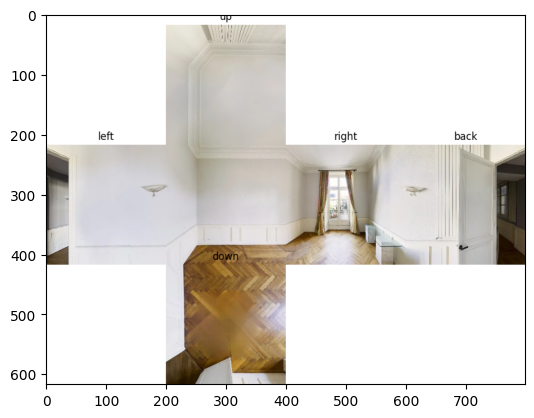

In [11]:
# read and show the cropped image
cubemap = cv2.imread('data/cubemap_tight.png')
cubemap = cv2.cvtColor(cubemap, cv2.COLOR_BGR2RGB) 
plt.imshow(cubemap)
plt.show()

To get the front  image, we have camera pose.
1. To get the up     image, we rotate camera pose on its own coordinates: x by pi/2.
1. To get the down   image, we rotate camera pose on its own coordinates: x by -pi/2.
1. To get the left   image, we rotate camera pose on its own coordinates: y by -pi/2.
1. To get the right  image, we rotate camera pose on its own coordinates: y by pi/2.
1. To get the bottom image, we rotate camera pose on its own coordinates: y by PI.

camera pose is c2w. 

In [12]:
c2w = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

def rotationx(theta: float) -> np.ndarray:
    """Rotation matrix around x axis"""
    c, s = np.cos(theta), np.sin(theta)
    rot = np.array([
        [1, 0, 0],
        [0, c, -s],
        [0, s, c]
    ])
    hom = np.eye(4)
    hom[:3, :3] = rot
    return hom

def rotationy(theta: float) -> np.ndarray:
    """Rotation matrix around y axis"""
    c, s = np.cos(theta), np.sin(theta)
    rot = np.array([
        [c, 0, s],
        [0, 1, 0],
        [-s, 0, c]
    ])
    hom = np.eye(4)
    hom[:3, :3] = rot
    return hom

def rotationz(theta: float) -> np.ndarray:
    """Rotation matrix around z axis"""
    c, s = np.cos(theta), np.sin(theta)
    rot = np.array([
        [c, -s, 0],
        [s, c, 0],
        [0, 0, 1]
    ])
    hom = np.eye(4)
    hom[:3, :3] = rot
    return hom

c2w_up = c2w @ rotationx(np.pi/2)
c2w_down = c2w @ rotationx(-np.pi/2)
c2w_left = c2w @ rotationy(-np.pi/2)
c2w_right = c2w @ rotationy(np.pi/2)
c2w_front = c2w
c2w_back = c2w @ rotationy(np.pi)
print("c2w_up: ")
print(c2w_up)
print("c2w_down: ")
print(c2w_down)
print("c2w_left: ")
print(c2w_left)
print("c2w_right: ")
print(c2w_right)
print("c2w_front: ")
print(c2w_front)
print("c2w_back: ")
print(c2w_back)

c2w_up: 
[[ 1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00]
 [ 0.000000e+00  6.123234e-17 -1.000000e+00  0.000000e+00]
 [ 0.000000e+00  1.000000e+00  6.123234e-17  0.000000e+00]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00]]
c2w_down: 
[[ 1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00]
 [ 0.000000e+00  6.123234e-17  1.000000e+00  0.000000e+00]
 [ 0.000000e+00 -1.000000e+00  6.123234e-17  0.000000e+00]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00]]
c2w_left: 
[[ 6.123234e-17  0.000000e+00 -1.000000e+00  0.000000e+00]
 [ 0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00]
 [ 1.000000e+00  0.000000e+00  6.123234e-17  0.000000e+00]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00]]
c2w_right: 
[[ 6.123234e-17  0.000000e+00  1.000000e+00  0.000000e+00]
 [ 0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00]
 [-1.000000e+00  0.000000e+00  6.123234e-17  0.000000e+00]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00]]
c2w_front

TODO:

As a demo, we show the correctness of the convertion by an open3d visualization. 

In [3]:
import open3d as o3d
# print version
print("Open3D version: ", o3d.__version__)
print("Load a ply point cloud, print it, and render it")
sample_ply_data = o3d.data.PLYPointCloud()
pcd = o3d.io.read_point_cloud(sample_ply_data.path)
o3d.visualization.draw_geometries([pcd])


Open3D version:  0.17.0
Load a ply point cloud, print it, and render it
